In [ ]:
# default_exp models

# neos.models

> Surrogate module to temorarily replace pyhf functionality.

In [ ]:
# export
import pyhf
import jax
from jax.config import config
from jax.experimental import stax

from neos.data import get_three_blobs
from neos.hists import hists_from_nn_bkg_var

# avoid those precision errors!
config.update("jax_enable_x64", True)

pyhf.set_backend(pyhf.tensor.jax_backend())

### multi-bin pyhf

In [ ]:
# export
class _Config(object):
    def __init__(self):
        self.poi_index = 0
        self.npars = 2

    def suggested_init(self):
        return jax.numpy.asarray([1.0, 1.0])

    def suggested_bounds(self):
        return jax.numpy.asarray(
            [jax.numpy.asarray([0.0, 10.0]), jax.numpy.asarray([0.0, 10.0])]
        )


class Model(object):
    def __init__(self, spec):
        self.sig, self.nominal, self.uncert = spec
        self.factor = (self.nominal / self.uncert) ** 2
        self.aux = 1.0 * self.factor
        self.config = _Config()

    def expected_data(self, pars, include_auxdata=True):
        mu, gamma = pars
        expected_main = jax.numpy.asarray([gamma * self.nominal + mu * self.sig])
        aux_data = jax.numpy.asarray([self.aux])
        return jax.numpy.concatenate([expected_main, aux_data])

    def logpdf(self, pars, data):
        maindata, auxdata = data
        main, _ = self.expected_data(pars)
        mu, gamma = pars
        main = pyhf.probability.Poisson(main).log_prob(maindata)
        constraint = pyhf.probability.Poisson(gamma * self.factor).log_prob(auxdata)
        # sum log probs over bins
        return jax.numpy.asarray([jax.numpy.sum(main + constraint,axis=0)])


def hepdata_like(signal_data, bkg_data, bkg_uncerts, batch_size=None):
    return Model([signal_data, bkg_data, bkg_uncerts])

In [ ]:
sig = jax.numpy.asarray([20,40,3])
bkg = jax.numpy.asarray([40,20,3])
un = jax.numpy.asarray([3,3,3])
m = hepdata_like(sig,bkg,un)
d = m.expected_data([1,1])
m.logpdf(pars=[1.,1.],data=d)

/home/phinate/envs/fullstream/lib/python3.7/site-packages/jax-0.1.58-py3.7.egg/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.


DeviceArray([-15.09130171], dtype=float64)

### 2-bin nn_model_maker, but only take first bin for now

In [ ]:
# export
def nn_model_maker(nn_params):
    # instantiate nn architecture
    _, predict = stax.serial(stax.Dense(5), stax.Relu, stax.Dense(2), stax.LogSoftmax)
    # grab data
    keys = [1, 2, 3]
    batch_size = 5000
    a, b, c = get_three_blobs(keys, batch_size)
    s, b, db = hists_from_nn_bkg_var(predict, nn_params, a, jax.numpy.asarray([b, c]))

    # arbitrary scaling:
    s, b, db = s / 5.0, b / 10.0, db / 10.0
    print(f"model: {s},{b},{db}")
    m = hepdata_like(s, b, db)
    nompars = m.config.suggested_init()
    bonlypars = jax.numpy.asarray([x for x in nompars])
    bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
    return m, bonlypars


Starting training...
Epoch 0 in 4.48 sec
Training set accuracy 0.8476
model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]


(<__main__.Model at 0x7f31880f42d0>, DeviceArray([0., 1.], dtype=float64))

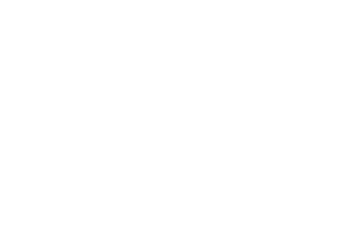

In [ ]:
from neos.nn import three_blob_classifier

x = three_blob_classifier()
_ = x.train(num_epochs=1)
nn_params = x.params

nn_model_maker(nn_params)